In [1]:
import pandas as pd
import os
import glob
import re
from underthesea import text_normalize, word_tokenize

In [10]:
test_csv_path, train_csv_path = glob.glob(os.path.join('data', 'ViVQA-csv', '*.csv'))
df_test = pd.read_csv(test_csv_path).drop(['Unnamed: 0'], axis=1)
df_train = pd.read_csv(train_csv_path).drop(['Unnamed: 0'], axis=1)

df_total = pd.concat([df_test, df_train], axis=0)
df_total.drop_duplicates(subset=list(df_total.columns), inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total

,question,answer,img_id,type
0,màu của miếng vá là gì,màu xanh dương,557067,2
1,màu của áo là gì,màu cam,436394,2
2,màu của áo là gì,màu xanh dương,541050,2
3,màu của căn phòng là gì,màu trắng,426077,2
4,màu của quả bóng là gì,màu đỏ,314710,2
...,...,...,...,...
14839,có bao nhiêu người cố gắng chặn người khác đan...,một,492171,1
14840,có bao nhiêu phụ nữ đang tạo dáng chụp ảnh tro...,hai,196378,1
14841,có bao nhiêu thanh niên đối đầu với nhau trong...,hai,524063,1
14842,có bao nhiêu cái bánh mì kẹp xúc xích đang ngồ...,hai,72955,1


In [11]:
df_total.to_csv('dataset.csv', index=False)

In [2]:
df = pd.read_csv('data/dataset.csv')
df.head()

,question,answer,img_id,type
0,màu của miếng vá là gì,màu xanh dương,557067,2
1,màu của áo là gì,màu cam,436394,2
2,màu của áo là gì,màu xanh dương,541050,2
3,màu của căn phòng là gì,màu trắng,426077,2
4,màu của quả bóng là gì,màu đỏ,314710,2


In [3]:
period_strip = re.compile(r'(?!<=\d)(\.)(?!\d)')
comma_strip = re.compile(r'(\d)(,)(\d)')
punctuation_chars = re.escape(r';/[]"{}()=+\_-><@`,?!.')
punctuation = re.compile(r'([{}])'.format(re.escape(punctuation_chars)))
punctuation_with_a_space = re.compile(r'(?<= )([{0}])|([{0}])(?= )'.format(punctuation_chars))

def process_punctuation(s):
    if punctuation.search(s) is None:
        return s
    s = punctuation_with_a_space.sub('', s)
    if re.search(comma_strip, s) is not None:
        s = s.replace(',', '')
    s = punctuation.sub(' ', s)
    s = period_strip.sub('', s)
    return s.strip()

In [4]:
from collections import Counter

def preprocess_questions(df):
    questions = [question.lower() for question in list(df['question'])]
    return questions

def preprocess_answers(df):
    answers = [process_punctuation(answer.lower()) for answer in list(df['answer'])]
    return answers


def extract_vocab(questions, answers):
    words = [word for question in questions for word in word_tokenize(question)]
    words = Counter(words).most_common()
    answers = Counter(answers).most_common()
    vocab_q = {word : i+1 for i, (word,_) in enumerate(words)}
    vocab_a = {answer: i for i, (answer,_) in enumerate(answers)}
    return vocab_q, vocab_a


questions = preprocess_questions(df)
answers = preprocess_answers(df)

vocab_q, vocab_a = extract_vocab(questions, answers)

In [5]:
import numpy as np
import torch
import torch.nn as nn

global x

def max_question_len(questions):
    return max([len(word_tokenize(question)) for question in questions])

def idx2word(vocab_dict):
    return {str(i): vocab for i, vocab in enumerate(vocab_dict)}

def questions_embedding(questions, vocab_q, embeding_dim):
    max_len = max_question_len(questions)
    vecs = []
    embedding = nn.Embedding(num_embeddings=len(vocab_q)+1, embedding_dim=embeding_dim, padding_idx=0)
    for question in questions:
        words = word_tokenize(question)
        vec = torch.zeros(max_len, dtype=torch.long)
        for i, word in enumerate(words):
            idx = vocab_q.get(word, 0)
            vec[i] = idx
        vecs.append(embedding(vec))
    return vecs

def encode_answers(answers, vocab_a):
    max_len = len(vocab_a)
    vecs = []
    for answer in answers:
        vec = torch.zeros(max_len)
        idx = vocab_a.get(answer)
        if idx is not None:
            vec[idx] = 1
            vecs.append(vec)
            continue

c:\Users\ngocs\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([26, 10])

In [30]:
class VocabDictionary:
    def __init__(self, ):
        pass

'bàn chải đánh răng .'

In [82]:
from torch.utils.data import Dataset
from utils import config
from utils import preprocess_questions, preprocess_answers
import json

class ViVQADataset(Dataset):
    def __init__(self, df):
        with open(config.__VOCAB__, 'r') as f:
            vocab = json.loads(f.read())
        
        self.vocab_q = vocab['question']
        self.vocab_a = vocab['answers']

        # q and a
        self.questions = self.encode_questions(preprocess_questions(df), self.vocab_q)
        self.answers = self.encode_answers(preprocess_answers(df), self.vocab_a)
        
        # v
        


    def encode_questions(self, questions, vocab_q):
        max_len = max_question_len(questions)
        vecs = []
        for question in questions:
            words = word_tokenize(question)
            vec = torch.zeros(max_len, dtype=torch.long)
            for i, word in enumerate(words):
                idx = vocab_q.get(word, 0)
                vec[i] = idx
            vecs.append(vec)
        return vecs
    
    def encode_answers(self, answers, vocab_a):
        max_len = len(vocab_a)
        vecs = []
        for answer in answers:
            vec = torch.zeros(max_len)
            idx = vocab_a.get(answer)
            if idx is not None:
                vec[idx] = 1
                vecs.append(vec)
                continue
        return vecs

ImportError: cannot import name 'preprocess_questions' from 'utils' (unknown location)

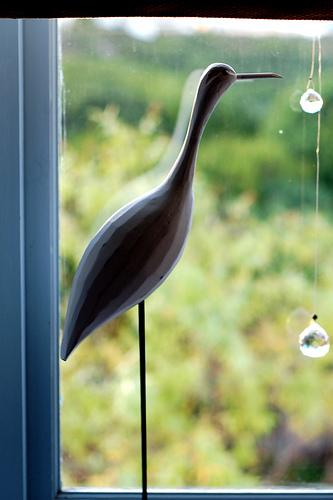

In [18]:
from torchvision.models import resnet152
import torch
from utils import config
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import glob

def get_transforms(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ViQAImages(Dataset):
    def __init__(self, path, transform=None):
        super(ViQAImages, self).__init__()
        self.path = path
        self.id2filename = self.generate_id2filename()
        self.ids = list(self.id2filename.keys())
        self.transform = transform

    def generate_id2filename(self):
        d = {}
        file_paths = sorted(glob.glob(os.path.join(self.path, '*.jpg')))
        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            id = file_name.split('.')[0]
            d[id] = file_name
        return d
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        file_name = self.id2filename[id]
        img = Image.open(os.path.join(self.path, file_name)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return id, img


obj = ViQAImages(path='data/images')
id, img = obj[0]
img

In [27]:
import torch
def tile(question_features, visual_features):
    batch_size, num_features = question_features.size()

    spatial_size = visual_features.dim() - 2
    tiled = question_features.view(batch_size, num_features, *([1]*spatial_size))
    return tiled

x = torch.tensor([[1,2,3,4]])
y = torch.zeros((1,7, 8, 8))
tile(x,y).size()

torch.Size([1, 4, 1, 1])

In [32]:
import torch

def tile(question_features, visual_features):
    batch_size, num_features = question_features.size()
    _, _, height, width = visual_features.size()
    
    spatial_size = visual_features.dim() - 2
    tiled = question_features.view(batch_size, num_features, *([1]*spatial_size)).expand(batch_size, num_features, height, width)
    
    return tiled

x = torch.tensor([[1, 2, 3, 4]])
y = torch.zeros((1, 7, 8, 8))
result = tile(x, y)
result


tensor([[[[1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1]],

         [[2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2]],

         [[3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3]],

         [[4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4,

In [62]:
import numpy as np
x = np.array([[[1,2,3,4],
            [5,6,7,8],
            [9,10,11,12],
]])

y = np.array([
    [[13,14,15,16]],
    [[17,18,19,20]]
])

z = x * y
np.sum((np.expand_dims(x, axis=(0,)) * np.expand_dims(y, axis=(0,))), axis=3)

array([[[150, 382, 614],
        [190, 486, 782]]])

In [43]:
z

array([[[ 13,  28,  45,  64],
        [ 65,  84, 105, 128],
        [117, 140, 165, 192]],

       [[ 17,  36,  57,  80],
        [ 85, 108, 133, 160],
        [153, 180, 209, 240]]])